In [194]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
!pip install nltk
import nltk
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import string
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score

In [195]:
df = pd.read_csv('../input/sms-detector/spam_v1.csv', encoding="ISO-8859-1")

In [196]:
df.sample(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
1427,ham,THING R GOOD THANX GOT EXAMS IN MARCH IVE DONE...,NaN,NaN,NaN
861,ham,Your brother is a genius,NaN,NaN,NaN
905,ham,Hey what's up charles sorry about the late reply.,NaN,NaN,NaN
2741,spam,I don't know u and u don't know me. Send CHAT ...,NaN,NaN,NaN
1087,ham,You can never do NOTHING,NaN,NaN,NaN


In [197]:
df.shape

(5572, 5)

## Data Cleaning

In [198]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [199]:
#drop last 3 columns 
df.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'], inplace=True)

In [200]:
df.sample(5)

,v1,v2
4841,ham,"Awesome, that gonna be soon or later tonight?"
691,ham,Sorry to trouble u again. Can buy 4d for my da...
1362,ham,What does the dance river do?
2709,ham,Sorry de i went to shop.
861,ham,Your brother is a genius


In [201]:
#renaming the columns
df.rename(columns={'v1':'target', 'v2':'text'}, inplace=True)
df.sample(5)

,target,text
507,ham,You should know now. So how's anthony. Are you...
3755,ham,Yes:)here tv is always available in work place..
2093,spam,Final Chance! Claim ur å£150 worth of discount...
1626,ham,Dear how you. Are you ok?
2038,ham,Hey are we going for the lo lesson or gym?


In [202]:
encoder = LabelEncoder()

In [203]:
df['target'] = encoder.fit_transform(df['target'])

In [204]:
df.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [205]:
#missing values
df.isnull().sum()

target    0
text      0
dtype: int64

In [206]:
# check for duplicate values
df.duplicated().sum()

403

In [207]:
# Removing Duplicate values
df = df.drop_duplicates(keep='first')

In [208]:
df.shape

(5169, 2)

**2.EDA**

In [209]:
df.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [210]:
df['target'].value_counts()

0    4516
1     653
Name: target, dtype: int64

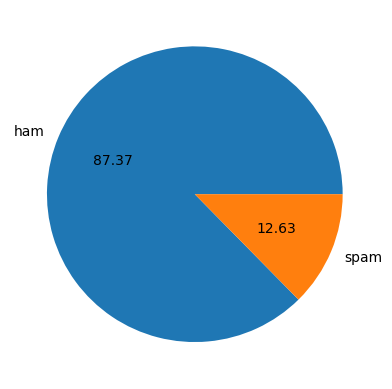

In [211]:
plt.pie(df['target'].value_counts(), labels=['ham','spam'], autopct='%0.2f')
plt.show()

In [212]:
# Data is imbalanced

In [213]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [214]:
df['num_characters'] = df['text'].apply(len)

In [215]:
df.head()

,target,text,num_characters
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


In [216]:
# num of words
df['num_words'] = df['text'].apply(lambda x:len(nltk.word_tokenize(x)))

In [217]:
df.head()

,target,text,num_characters,num_words
0,0,"Go until jurong point, crazy.. Available only ...",111,23
1,0,Ok lar... Joking wif u oni...,29,8
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37
3,0,U dun say so early hor... U c already then say...,49,13
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15


In [218]:
df['num_sentences'] = df['text'].apply(lambda x:len(nltk.sent_tokenize(x)))

In [219]:
df.head()

,target,text,num_characters,num_words,num_sentences
0,0,"Go until jurong point, crazy.. Available only ...",111,23,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [220]:
df[['num_characters', 'num_words', 'num_sentences']].describe()

,num_characters,num_words,num_sentences
count,5169.000000,5169.000000,5169.000000
mean,78.977945,18.286129,1.961308
std,58.236293,13.226400,1.432583
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,60.000000,15.000000,1.000000
75%,117.000000,26.000000,2.000000
max,910.000000,219.000000,38.000000


In [221]:
# Ham
df[df['target'] == 0][['num_characters', 'num_words', 'num_sentences']].describe()

,num_characters,num_words,num_sentences
count,4516.000000,4516.000000,4516.000000
mean,70.459256,16.957484,1.815545
std,56.358207,13.394052,1.364098
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,219.000000,38.000000


In [222]:
# Spam
df[df['target'] == 1][['num_characters', 'num_words', 'num_sentences']].describe()

,num_characters,num_words,num_sentences
count,653.000000,653.000000,653.000000
mean,137.891271,27.474732,2.969372
std,30.137753,6.893007,1.488910
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,44.000000,9.000000


<Axes: xlabel='num_characters', ylabel='Count'>

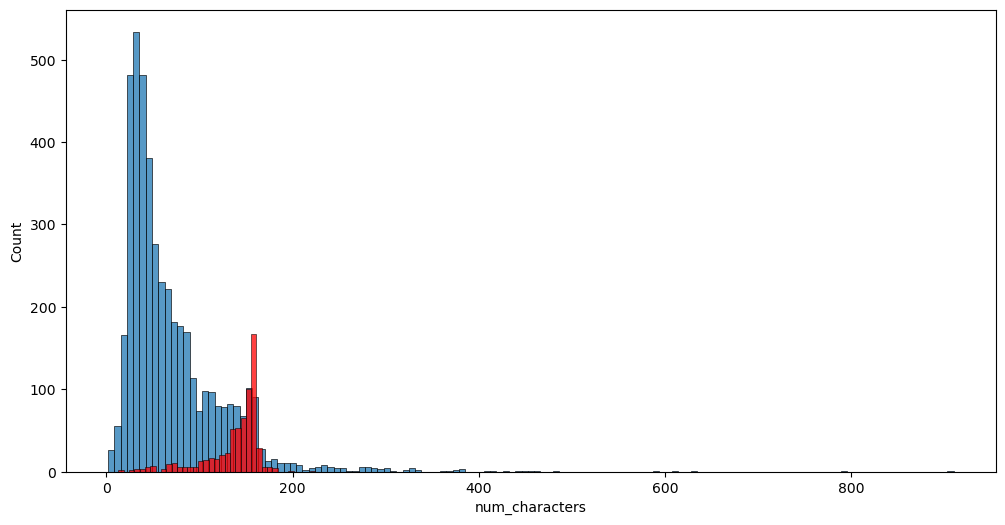

In [223]:
plt.figure(figsize=(12,6))
sns.histplot(df[df['target'] == 0]['num_characters'])
sns.histplot(df[df['target'] == 1]['num_characters'],color='red')

<Axes: xlabel='num_words', ylabel='Count'>

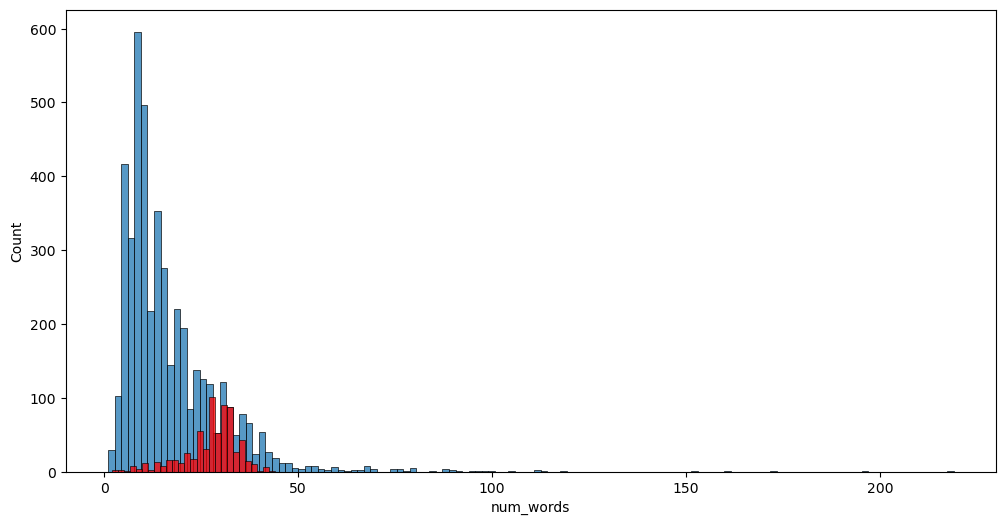

In [224]:
plt.figure(figsize=(12,6))
sns.histplot(df[df['target'] == 0]['num_words'])
sns.histplot(df[df['target'] == 1]['num_words'],color='red')

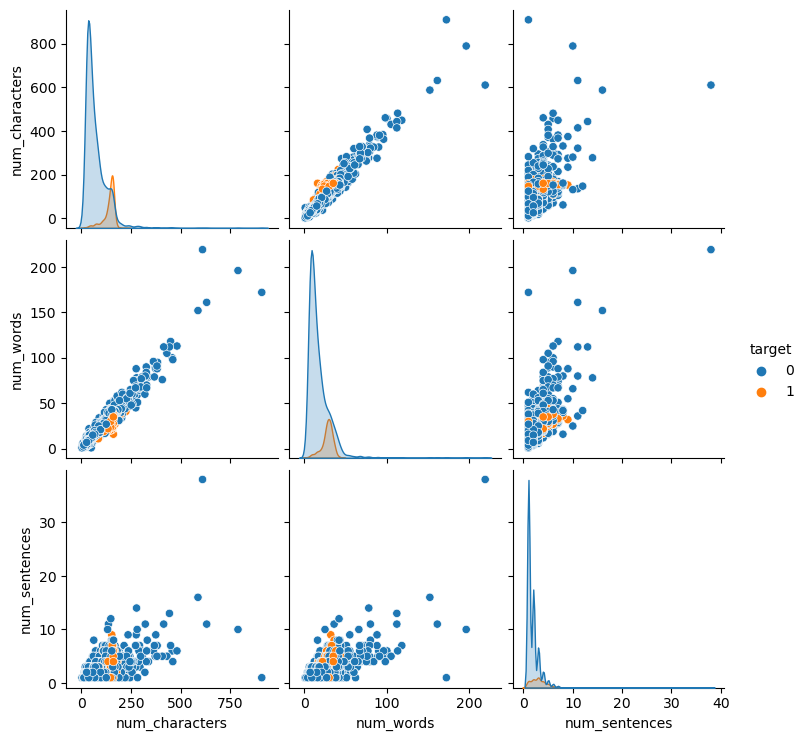

In [225]:
sns.pairplot(df, hue="target")

/tmp/ipykernel_32/621126171.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True)


<Axes: >

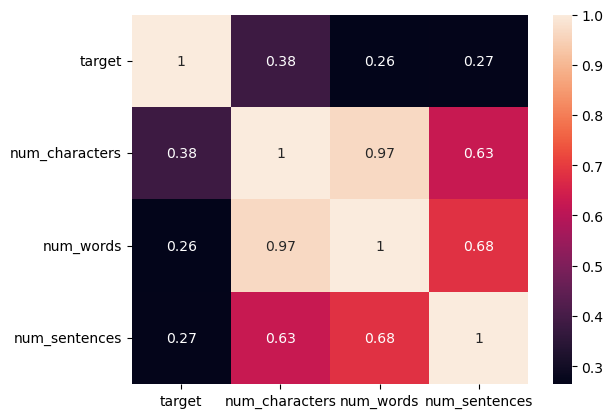

In [226]:
sns.heatmap(df.corr(), annot=True)

**Data preprocessing**
* lowercase
* Tokenization
* Removing special characters
* Removing stop word and punctuation
* Stemming

In [227]:
ps = PorterStemmer()

In [228]:
def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    
    y=[]
    for i in text:
        if i.isalnum():
            y.append(i)
            
    text = y[:]
    y.clear()
    
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
            
    text = y[:]
    y.clear()
    for i in text:
        y.append(ps.stem(i))
        
    return " ".join(y)


In [229]:
transform_text("I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today.")

'gon na home soon want talk stuff anymor tonight k cri enough today'

In [230]:
df['text'][10]

"I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today."

In [231]:
df['transform_text'] = df['text'].apply(transform_text)

In [232]:
df.head()

,target,text,num_characters,num_words,num_sentences,transform_text
0,0,"Go until jurong point, crazy.. Available only ...",111,23,2,go jurong point avail bugi n great world la e ...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


In [233]:
# word cloud
wc = WordCloud(width=500, height= 500, min_font_size= 10, background_color="white")

In [234]:
spam_wc = wc.generate(df[df['target']==1]['transform_text'].str.cat(sep=" "))

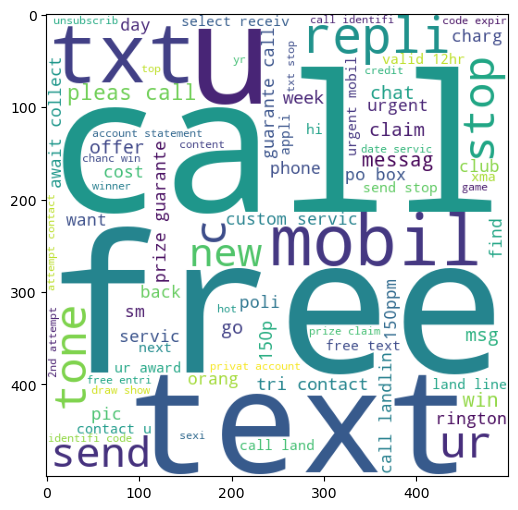

In [235]:
plt.figure(figsize=(15,6))
plt.imshow(spam_wc)

In [236]:
df.head()

,target,text,num_characters,num_words,num_sentences,transform_text
0,0,"Go until jurong point, crazy.. Available only ...",111,23,2,go jurong point avail bugi n great world la e ...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


In [237]:
ham_wc = wc.generate(df[df['target']==0]['transform_text'].str.cat(sep=" "))

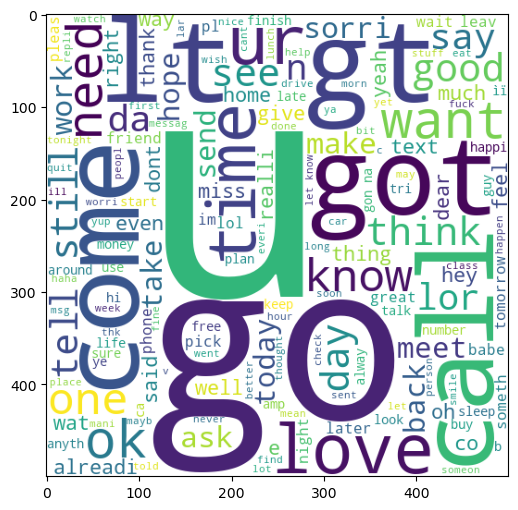

In [238]:
plt.figure(figsize=(15,6))
plt.imshow(spam_wc)

In [239]:
#top 30 words
spam_corpus = []
for msg in df[df['target'] == 1]['transform_text'].tolist():
    for words in msg.split():
        spam_corpus.append(words)

In [240]:
len(spam_corpus)

9883

In [241]:
spam_corpus = []
for msg in df[df['target'] == 0]['transform_text'].tolist():
    for words in msg.split():
        spam_corpus.append(words)

In [242]:
len(spam_corpus)

34771

**4. Model Building**

In [243]:
cv = CountVectorizer()
tfidf = TfidfVectorizer()

In [244]:
# X = cv.fit_transform(df['transform_text']).toarray()
X = tfidf.fit_transform(df['transform_text']).toarray()

In [245]:
X.shape

(5169, 6629)

In [246]:
y = df['target'].values

In [247]:
y

array([0, 0, 1, ..., 0, 0, 0])

In [248]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25, random_state = 2)

In [249]:
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()

In [250]:
gnb.fit(X_train, y_train)
y_pred1 =  gnb.predict(X_test)
accuracy_score(y_test, y_pred1)
print(accuracy_score(y_test, y_pred1))
print(confusion_matrix(y_test, y_pred1))
print(precision_score(y_test, y_pred1))

0.8623356535189481
[[982 148]
 [ 30 133]]
0.47330960854092524


In [251]:
mnb.fit(X_train, y_train)
y_pred2 =  mnb.predict(X_test)
accuracy_score(y_test, y_pred1)
print(accuracy_score(y_test, y_pred2))
print(confusion_matrix(y_test, y_pred2))
print(precision_score(y_test, y_pred2))

0.9590100541376644
[[1130    0]
 [  53  110]]
1.0


In [252]:
bnb.fit(X_train, y_train)
y_pred3 =  bnb.predict(X_test)
accuracy_score(y_test, y_pred1)
print(accuracy_score(y_test, y_pred3))
print(confusion_matrix(y_test, y_pred3))
print(precision_score(y_test, y_pred3))

0.9698375870069605
[[1127    3]
 [  36  127]]
0.9769230769230769


In [253]:
# tfidf --> MNB 

In [254]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

In [255]:
svc = SVC(kernel='sigmoid', gamma=1.0)
mnb = MultinomialNB()
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50,random_state=2)
xgb = XGBClassifier(n_estimators=50,random_state=2)

In [256]:
clfs = {
    'SVC' : svc,
    'NB': mnb, 
    'LR': lrc, 
    'RF': rfc, 
    'GBDT':gbdt,
    'xgb':xgb
}

In [257]:
def train_classifier(clf,X_train,y_train,X_test,y_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    
    return accuracy,precision

In [258]:
train_classifier(svc,X_train,y_train,X_test,y_test)

(0.9729311678267595, 0.9705882352941176)

In [259]:
accuracy_scores = []
precision_scores = []

for name,clf in clfs.items():
    
    current_accuracy,current_precision = train_classifier(clf, X_train,y_train,X_test,y_test)
    
    print("For ",name)
    print("Accuracy - ",current_accuracy)
    print("Precision - ",current_precision)
    
    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)

For  SVC
Accuracy -  0.9729311678267595
Precision -  0.9705882352941176
For  NB
Accuracy -  0.9590100541376644
Precision -  1.0
For  LR
Accuracy -  0.9528228924980665
Precision -  0.9396551724137931
For  RF
Accuracy -  0.974477958236659
Precision -  0.9850746268656716
For  GBDT
Accuracy -  0.9520494972931168
Precision -  0.8976377952755905
For  xgb
Accuracy -  0.9659706109822119
Precision -  0.9280575539568345


In [260]:
import pickle
pickle.dump(tfidf,open('vectorizer.pkl','wb'))
pickle.dump(mnb,open('model.pkl','wb'))